This notebook examines pig and poultry farms in the US. It is intended to help illustrate the distributions of building areas, lentghs, and aspect ratios associated with these farms. Currently, two datasets are investigated:

1. A set of ~6000 poultry barns in the Delmarva Peninsula. These were collected by the USGS. The coordinates refer to actual buildings, and the shapefile contains building areas, so it is possible to directly analyze the building footprints. The authiors do not distinguish between broiler chickens, laying hens, and any other birds, and no other information about the farms (e.g. number of animals) is available.

2. A set of about 3000 liquid pig manure storage facilities in North Carolina. The lagoon coordinates were derived by Montefiore et al. from official permit information. The coordinates refer to lagoon centroids. The only other information contained in the files is the estimated year of lagoon construction. As the coordinates of farm buildings are not supplied, they must be obtained from the global building footprint database.

In [ ]:
#!pip install pyogrio==0.7.2 geopandas==0.14.3 unidecode

In [ ]:
%load_ext autoreload
%autoreload 2

import os, sys
from google.colab import drive
import ee
import geemap.foliumap as geemap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils, explore

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The Delmarva dataset contains the building footprint information we need, so it is very easy to work with. We'll look at this one first.

In [ ]:
# Read in the DMV data and calculate lengths and aspect ratios

f = "/content/drive/MyDrive/CAFO_data/USA/Delmarva_PL_House_Final/Delmarva_PL_House_Final2.shp"
dmv = gpd.read_file(f)
display(dmv.head(2))

temp = dmv['geometry'].minimum_rotated_rectangle().to_crs('EPSG:32618')
dmv[['Length', 'Aspect Ratio']] = temp.apply(explore.calc_length_etc)

,AreaMeters,geometry
0,2148,"POLYGON Z ((441154.142 4180879.337 0.000, 4410..."
1,3658,"POLYGON Z ((441081.382 4180936.884 0.000, 4409..."


,AreaMeters,Length,Aspect Ratio
Min,526.0,51.048241,3.289669
Med,2319.0,153.258935,8.677511
Max,8107.0,247.856798,20.172176


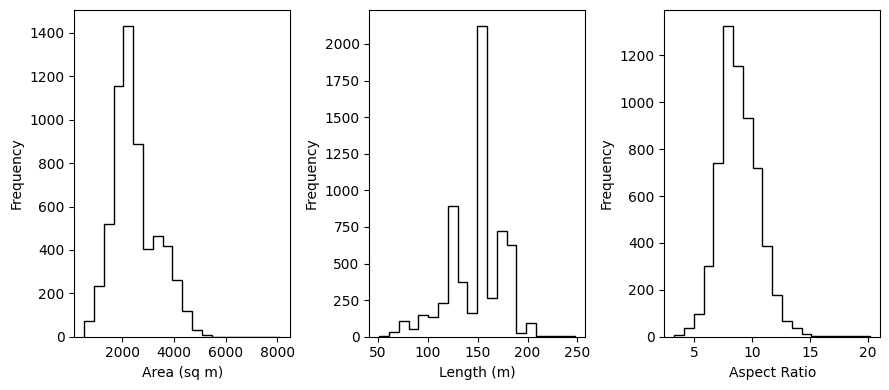

In [ ]:
# Make histograms, calculate stats, save to file

def show_n_save(df, area_col, fig_name, df_name):

  _, axes = plt.subplots(1, 3, figsize=(9, 4))

  cols = [area_col, 'Length', 'Aspect Ratio']
  labels = ['Area (sq m)', 'Length (m)', 'Aspect Ratio']
  stats = {}
  for ax, col, label in zip(axes, cols, labels):
    ax.hist(df[col], bins=20, color='k', histtype='step')
    ax.set_xlabel(label)
    ax.set_ylabel('Frequency')
    stats[col] = (df[col].min(), df[col].median(), df[col].max())

  plt.tight_layout()
  if fig_name is not None:
    plt.savefig(f'/content/drive/MyDrive/CAFO_data/Analysis/{fig_name}.png')

  stats_df = pd.DataFrame(stats, index=["Min", "Med", "Max"])
  display(stats_df)
  if df_name is not None:
    stats_df.to_pickle(f'/content/drive/MyDrive/CAFO_data/Analysis/{df_name}.pkl')

show_n_save(dmv, "AreaMeters", "DMV_poultry_bldg_histos.png", "DMV_poultry_bldg_stats")

Now we'll look at the North Carolina Data. This is more involved because we only have lagoon locations, not building locations. We'll get building locations by finding buildings within a certain distance of the lagoons. This probably means we miss some buildings and include others that aren't relevant, depending on farm characteristics, but we'll have to live with that.

In [ ]:
# Read the lagoon data

lagoons = gpd.read_file("/content/drive/MyDrive/CAFO_data/USA/Montefiore.shp").to_crs("EPSG:4326")
print(f"There are {len(lagoons)} lagoons in the dataset")
display(lagoons.head(2))

lagoons.drop(columns=["field_1", "field_2"], inplace=True)
lagoons_fc = geemap.geopandas_to_ee(lagoons[["geometry"]])

There are 3405 lagoons in the dataset


,field_1,field_2,field_3,geometry
0,-77.749305,35.405879,1986,POINT (-77.74930 35.40588)
1,-77.657782,35.391965,1986,POINT (-77.65778 35.39197)


In [ ]:
# Read the NC state shapefile and find all buildings above 200 sq m
# We have to exclude small buildings to keep the data volume manageable
# (Even so, we still end up with about 2 million buildings)

nc = gpd.read_file('/content/drive/MyDrive/CAFO_data/USA/cb_2021_us_state_5m.shp')
nc = nc[nc['NAME'].str.match('North Carolina')]
nc_geom = geemap.geopandas_to_ee(nc[['geometry']])

min_building_size = 200

buildings = (
      ee.FeatureCollection(f"projects/sat-io/open-datasets/VIDA_COMBINED/USA")
      .filter(ee.Filter.gt('area_in_meters', min_building_size))
      .filterBounds(nc_geom)
)

In [ ]:
# Show all buildings and lagoons on a map. I've only looked at this map a little
# bit, as a basic sanity check. However, I've worked with this dataset before and
# I expect everything to be OK.

Map = geemap.Map()
Map.centerObject(nc_geom.first().geometry(), 10)

os.environ["HYBRID"] = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'

region_viz = {'color':'red', 'fillColor':'00000000'}
building_viz = {'color':'orange', 'fillColor':'00000000'}

Map.add_basemap("HYBRID")
Map.addLayer(buildings.style(**building_viz), {}, "")
Map.addLayer(lagoons_fc, {'color':'pink', 'width':6}, "Pig lagoons")

Map

In [ ]:
# Save the buildings to a file for future use. This is time-consuming so leave
# this cell commented out unless there's a reason to recreate the file.

#utils.write_to_file(buildings, f"NC_{min_building_size}m2", 'USA')
#utils.ee_task_status()

In [ ]:
# Read the data into a geodataframe

gdf = gpd.read_file(f"/content/drive/MyDrive/CAFO_data/USA/NC_{min_building_size}m2.geojson")
print(f"There are {len(gdf)} buildings > {min_building_size} sq m")

There are 1955891 buildings > 200 sq m


In [ ]:
# Do a spatial join to find all the buildings that are within <dist> m of a
# lagoon (i.e., that intersect with a buffer of <dist> m around the lagoon centroid).
# Also, calculate their lengths and aspect ratios.

dist = 150
pig_buildings = explore.join_farms_and_buildings(lagoons, gdf, dist)

# Some farms have >1 lagoon, so their buildings will get counted multiple times
# Drop these duplicate buildings
pig_buildings.drop_duplicates(subset=["index_right"], inplace=True)

pig_bldgs_2 = explore.get_dimensions(pig_buildings, crs="EPSG:32119")
print(f"There are {len(pig_bldgs_2)} buildings within {dist} m of a lagoon ")

There are 10298 buildings within 150 m of a lagoon 


,area_in_meters,Length,Aspect Ratio
Min,200.091240,14.959630,1.001920
Med,689.978672,51.148263,3.566545
Max,15686.996047,258.253074,16.172826


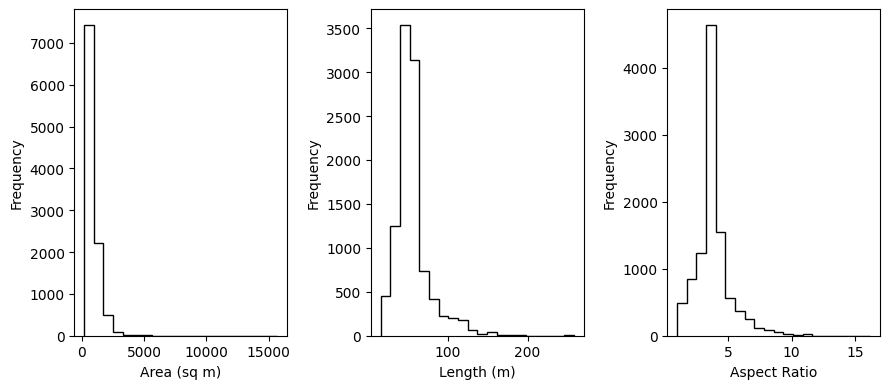

In [ ]:
# Plot histograms of building characteristics. I am suspicious of these super
# huge buildings in these plots, so in the next cell we'll put them on a map
# and take a closer look.

show_n_save(pig_bldgs_2, "area_in_meters", None, None)

In [ ]:
# Between about 3000-4000 sq m, the buildings are either just large or they are
# connected by a structure that means that two or more buildings get identified
# as a single one in the building footprint database. Above about 4000 m, they
# are multiple buildings that get merged into a single one. So I think it makes
# sense to plot only buildings < 4000 m.

# What are relatively small buildings, from 200-400 sq m? I think a lot of them
# are random farm buildings (not animal housing). A few are inaccurate footprints,
# and some are actually small pig houses. So there is definitely some noise at
# this end, but I don't see any justification for actually excluding these data
# points.

size_range = (200, 400)
temp = pig_bldgs_2[(pig_bldgs_2['area_in_meters'] > size_range[0]) &\
                   (pig_bldgs_2['area_in_meters'] < size_range[1])]
print(f"There are {len(temp)} buildings in this size range")
fc = geemap.geopandas_to_ee(temp[['geometry']])
temp2 = temp.set_geometry("buildings_geom")
fc2 = geemap.geopandas_to_ee(temp2[['buildings_geom']])

Map = geemap.Map()
Map.centerObject(fc.first().geometry(), 16)
Map.add_basemap("HYBRID")
Map.addLayer(buildings.style(**building_viz), {}, "All buildings")
Map.addLayer(lagoons_fc, {'color':'pink', 'width':6}, "All pig lagoons")
Map.addLayer(fc, {'color':'red', 'width':6}, "Lagoons w/ bldgs in size range")
Map.addLayer(fc2, {'color':'cyan', 'fillColor':'00000000'}, "Lagoon bldgs in size range")

Map

There are 1194 buildings in this size range


,area_in_meters,Length,Aspect Ratio
Min,200.091240,14.959630,1.001920
Med,688.907481,51.103269,3.567157
Max,3947.458990,191.357904,16.172826


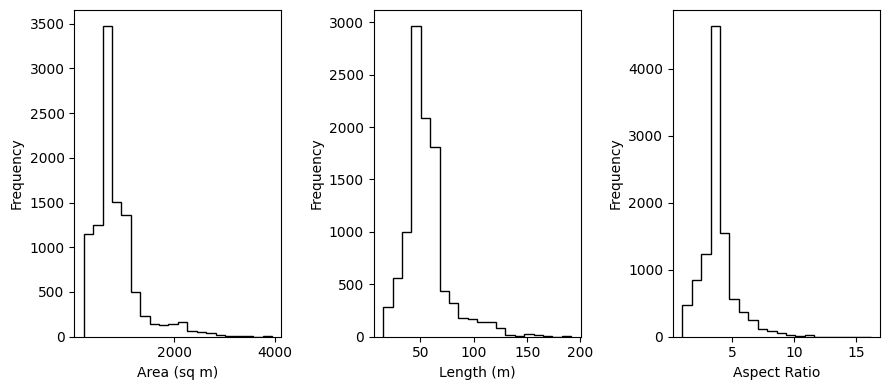

In [ ]:
# Let's make histograms and calculate stats excluding buildings > 4000 sq m.

max_size = 4000
real_bldgs = pig_bldgs_2[pig_bldgs_2['area_in_meters'] < max_size]
show_n_save(real_bldgs, "area_in_meters", "NC_pig_bldg_histos", "NC_pig_bldg_stats")

We have the estimated construction year for each lagoon. Is there any trend in building size with lagoon construction year? Note that lagoons with year=1986 could have been constructed prior to 1986 (if I remember the Montefiore paper correctly), and we only have estimated construction years for *lagoons*, not *buildings*.

I don't see anything useful in the plot below. It's sort of striking that the variety of building sizes decreases after the late 1990s, but that could be to do with the moratorium and the smaller number of lagoons built since then.

Text(0, 0.5, 'Areas of buildings (sq m) within 150 m')

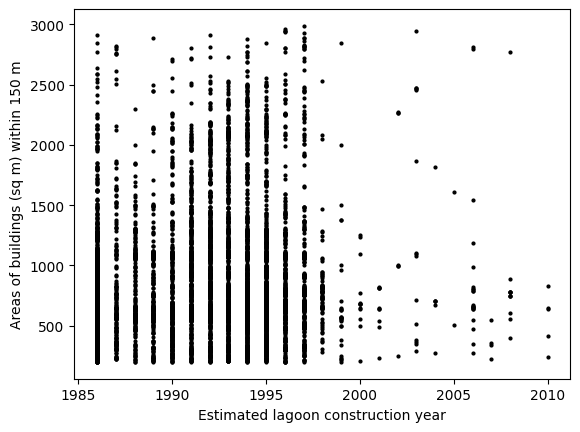

In [ ]:
plt.scatter(real_bldgs['field_3'], real_bldgs['area_in_meters'], marker='o',\
            s=4, color='k')
plt.xlabel("Estimated lagoon construction year")
plt.ylabel(f"Areas of buildings (sq m) within {dist} m")

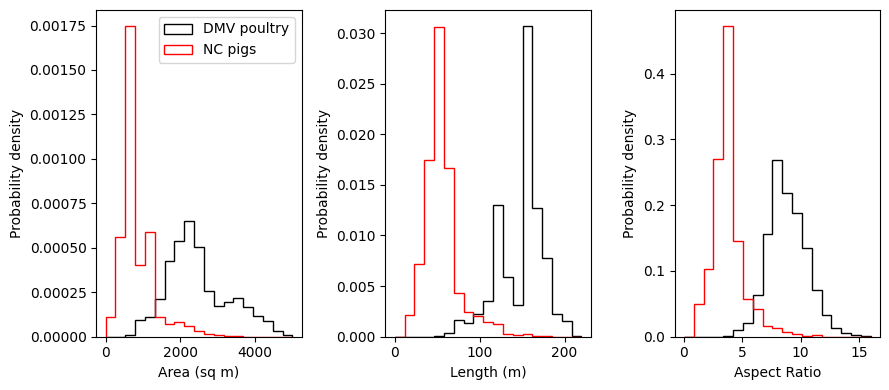

In [ ]:
# Now let's look at the pig and poultry data at the same time
# We'll define consistent bins for both datasets

_, axes = plt.subplots(1, 3, figsize=(9, 4))

# Should have done this above
dmv["Area"] = dmv["AreaMeters"]
real_bldgs["Area"] = real_bldgs["area_in_meters"]

cols = ['Area', 'Length', 'Aspect Ratio']
labels = ['Area (sq m)', 'Length (m)', 'Aspect Ratio']

binses = (np.linspace(0, 5000, 20),\
          np.linspace(0, 220, 20),\
          np.linspace(0, 16, 20))

for ax, col, label, bins in zip(axes, cols, labels, binses):
  for df, color, leg in  zip([dmv, real_bldgs], ['k', 'r'], ['DMV poultry', 'NC pigs']):
    ax.hist(df[col], bins=bins, color=color, histtype='step', density=True,\
            label=leg)
  if col == "Area":
    ax.legend()
  ax.set_xlabel(label)
  ax.set_ylabel('Probability density')

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/CAFO_data/Analysis/DMV_NC.png')